## Hands-on introduction to Deep Learning

**Author: Dr. Dimitrios Tanoglidis**, Incoming Data Science Fellow @UPenn, PhD @UChicago

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/140LcaibWwFnMOAStOejS7tsaWm918dGB#scrollTo=5TSCmnkkSHvT)

In this notebook we give a practical, **hands-on** introduction to deep learning/neural networks, by solving a real research problem we encountered in astrophysics.

We will show how a neural network able to distinguish between **extremely faint galaxies** and **artifacts** in astrophysical images. For more information, and a more complex model, see the related research paper: https://arxiv.org/abs/2011.12437





**Import libraries and packages**

Here we import some python libraries we are going to need for the rest of excersize.

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import random

# =========================================
# scikit-learn for Machine Learning - Here we use only the metrics

# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# =======================================
# Tensorflow and Keras 
# We are going to use this for 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()


### Import datasets

Let's import the image datasets.

Now these are large, 30k for training, 5k for validation and 5k for testing.

Here, in order to speed up the process, we will keep a subset of these.

We need:

- `X_tr, X_val, X_test`: Refer to the training, validation and test sets for the image-based classification (deep learning).

- `y_tr, y_val, y_test`: Labels - training, validation and test sets.

In [2]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# For image-based classification
X_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_train.npy"))[:4000] #Training
X_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_val.npy"))[:500] #Validation
X_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_test.npy"))[:500] #Test

# Labels
y_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_train.npy"))[:4000] # Training
y_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_val.npy"))[:500] #Validation
y_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_test.npy"))[:500] #Test

### Plot examples of Low-Surface-Brightness galaxies (LSBGs) and artifacts

It is always a good practice to check our dataset. 

Here we have images. If we had some numerical properties (features) we could make and inspect some histograms. 

Never apply fancy models before you get a sense of your data first.

In [4]:
X_pos = X_tr[y_tr==1.] #Positives - LSBGs
X_neg = X_tr[y_tr==0.] #Negatives - Artifacts

randind = np.random.randint(0,1000,20)

X_sample_LSBG = X_pos[randind]
X_sample_Artefacts = X_neg[randind]

- Plot examples of LSBGs

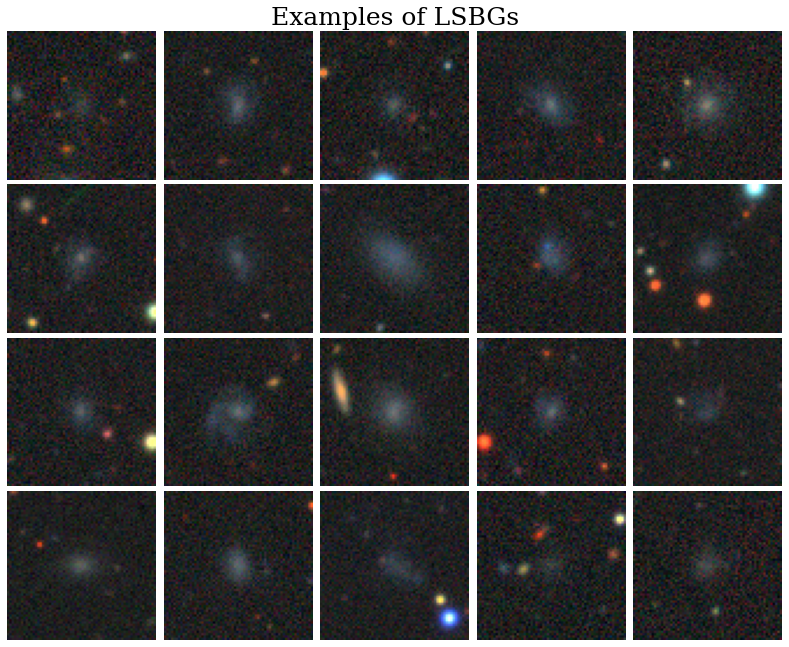

In [5]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

- Plot examples of Artifacts

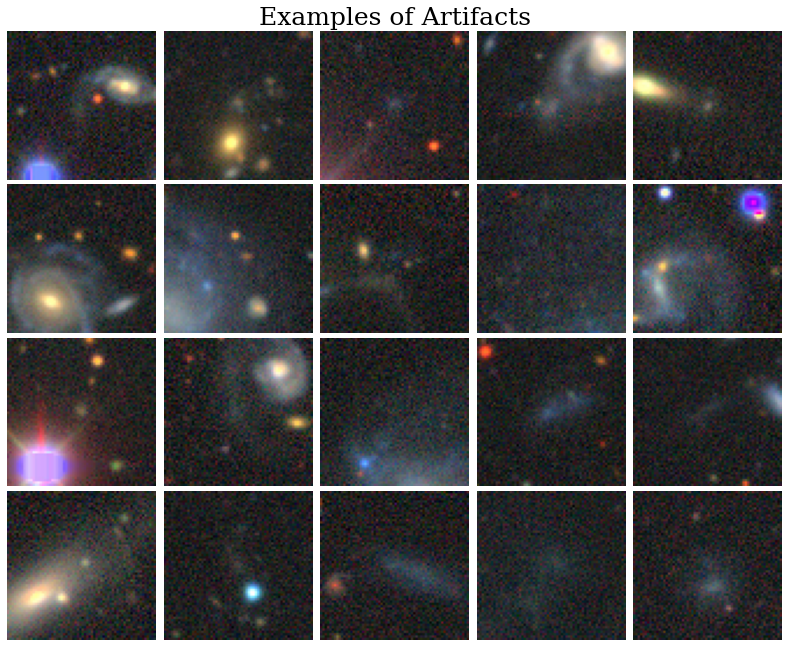

In [6]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_Artefacts[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()


### **Build a deep learning model**

We call this model **DeepShadows** (for obvious reasons... check images above)

In [7]:
# build the  original model in Keras
model = keras.models.Sequential()
model.add(InputLayer((64,64,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer=optimizers.Adadelta(0.1),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [8]:
n_epochs = 30 # Number of epochs


model.fit(x=X_tr, y=y_tr,
          epochs=n_epochs, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))

Epoch 1/30
63/63 [==============================] - 16s 25ms/step - loss: 168.1175 - accuracy: 0.6735 - val_loss: 133.0181 - val_accuracy: 0.5060
Epoch 2/30
63/63 [==============================] - 1s 20ms/step - loss: 108.1769 - accuracy: 0.7680 - val_loss: 85.8479 - val_accuracy: 0.6840
Epoch 3/30
63/63 [==============================] - 1s 14ms/step - loss: 69.7270 - accuracy: 0.7903 - val_loss: 55.5215 - val_accuracy: 0.5060
Epoch 4/30
63/63 [==============================] - 1s 12ms/step - loss: 44.6353 - accuracy: 0.8170 - val_loss: 35.3110 - val_accuracy: 0.5060
Epoch 5/30
63/63 [==============================] - 1s 12ms/step - loss: 28.3936 - accuracy: 0.8375 - val_loss: 22.6928 - val_accuracy: 0.5060
Epoch 6/30
63/63 [==============================] - 1s 12ms/step - loss: 18.1562 - accuracy: 0.8493 - val_loss: 14.5482 - val_accuracy: 0.7640
Epoch 7/30
63/63 [==============================] - 1s 12ms/step - loss: 11.8170 - accuracy: 0.8545 - val_loss: 9.6156 - val_accuracy: 0.7

### Evaluation of the model

We have trained the deep learning model (DeepShadows), meaning that is able to make predictions on new, unseen, examples.

